# Classic ARIMA Model - Baseline
We usd ARIMA as our baseline to forecast future stock prices.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Load and Preprocess Data

In [4]:
# Load and preprocess data
df = pd.read_csv('./berkshire_hathaway_data.csv', index_col=0, parse_dates=True)
df = df[df.index >= '2020-01-01']
df = df.asfreq('D').fillna(method='ffill')
df['log_Close'] = np.log(df['Close'])
df['date_ordinal'] = df.index.map(lambda date: date.toordinal())
print(df)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-01-02  227.509995  228.389999  226.710007  228.389999  228.389999   
2020-01-03  225.690002  227.429993  225.479996  226.179993  226.179993   
2020-01-04  225.690002  227.429993  225.479996  226.179993  226.179993   
2020-01-05  225.690002  227.429993  225.479996  226.179993  226.179993   
2020-01-06  224.990005  227.130005  224.699997  226.990005  226.990005   
...                ...         ...         ...         ...         ...   
2024-07-25  431.600006  439.630005  431.600006  433.290009  433.290009   
2024-07-26  435.660004  439.000000  434.100006  437.660004  437.660004   
2024-07-27  435.660004  439.000000  434.100006  437.660004  437.660004   
2024-07-28  435.660004  439.000000  434.100006  437.660004  437.660004   
2024-07-29  438.010010  439.440002  435.489990  438.309998  438.309998   

               Volume  log_Close  dat

### Stationarity Handler
To make sure ARIMA works properly, we remove trends and make the data more stationary.


Test Statistic: -0.5218750340147723
P-Value: 0.8876765782218701
Stationary | D=1
(-0.5218750340147723, 0.8876765782218701, 11, 1659, {'1%': -3.4342978282123258, '5%': -2.8632837412222885, '10%': -2.567698326213784}, -10057.536085265187)


<Axes: xlabel='Date'>

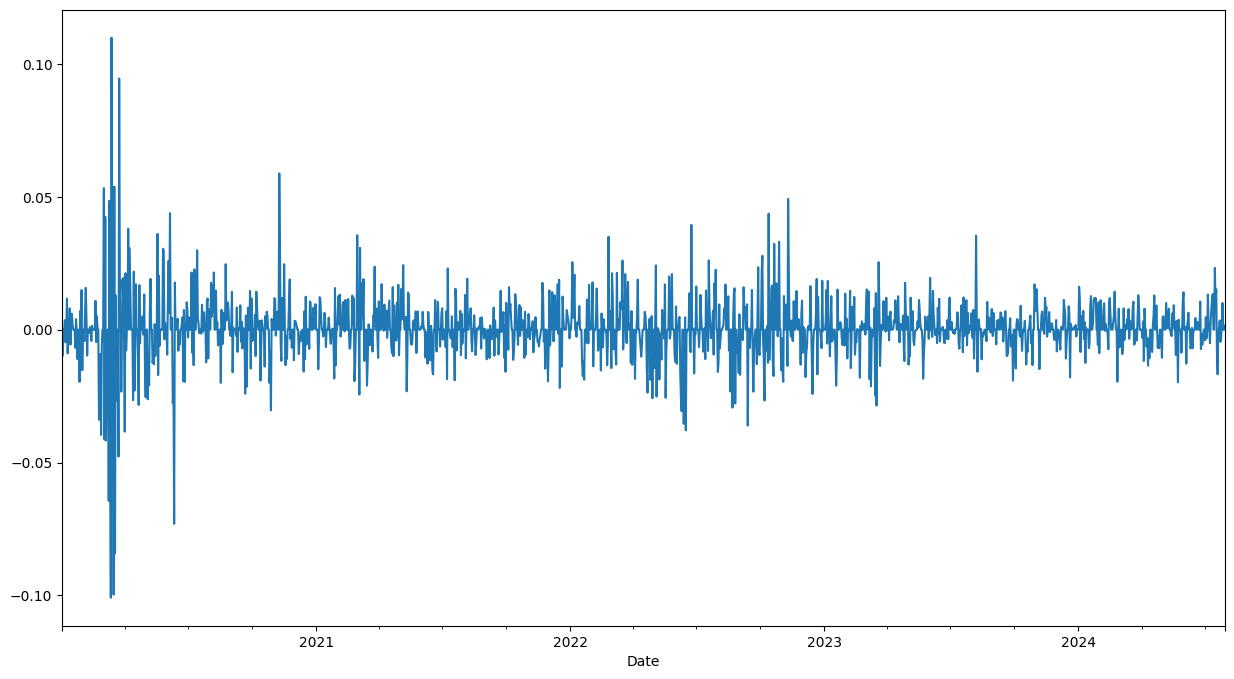

In [5]:
result = adfuller(df['log_Close'].dropna())

print("Test Statistic:", result[0])
print("P-Value:", result[1])

df['diff_log_Close'] = df['log_Close'].diff().dropna()
if(df['diff_log_Close'][1] < 0.05):
    print("Stationary | D=1")
else:
    print("Non-Stationary")

print(result)

# Plot
df['diff_log_Close'].plot(figsize=(15,8))

# Plot PACF + ACF
The purpose of this si to 

C:\Users\Danyil\AppData\Local\Temp\ipykernel_19576\3814576331.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_pacf.show()
C:\Users\Danyil\AppData\Local\Temp\ipykernel_19576\3814576331.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_pacf.show()


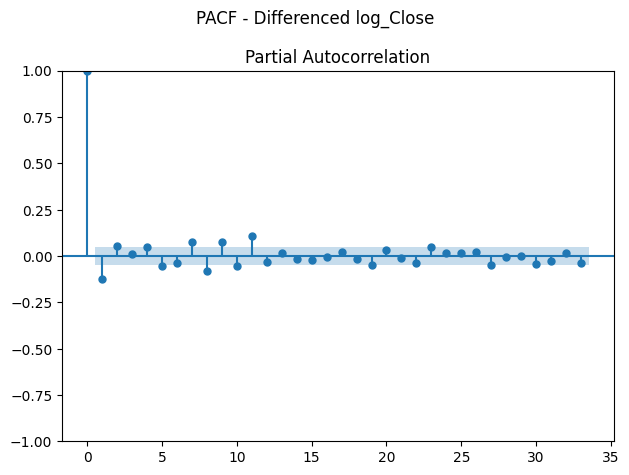

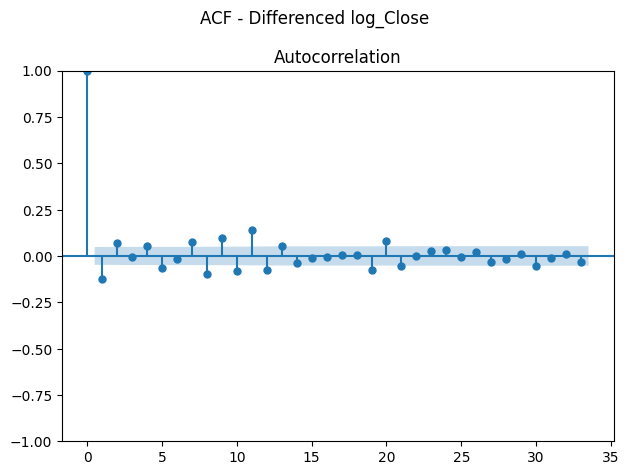

In [6]:
# PACF
fig_pacf = plot_pacf(df['diff_log_Close'].dropna(), method='ywm')
fig_pacf.suptitle("PACF - Differenced log_Close")
fig_pacf.tight_layout()
fig_pacf.show()

# ACF
fig_acf = plot_acf(df['diff_log_Close'].dropna())
fig_acf.suptitle("ACF - Differenced log_Close")
fig_acf.tight_layout()
fig_pacf.show()

### ARIMA Train Model
Using the information provided from the graphs, we are going to use this to train our model. For our testing, we decided to predict using the last 30 days to predict the next 30 days.

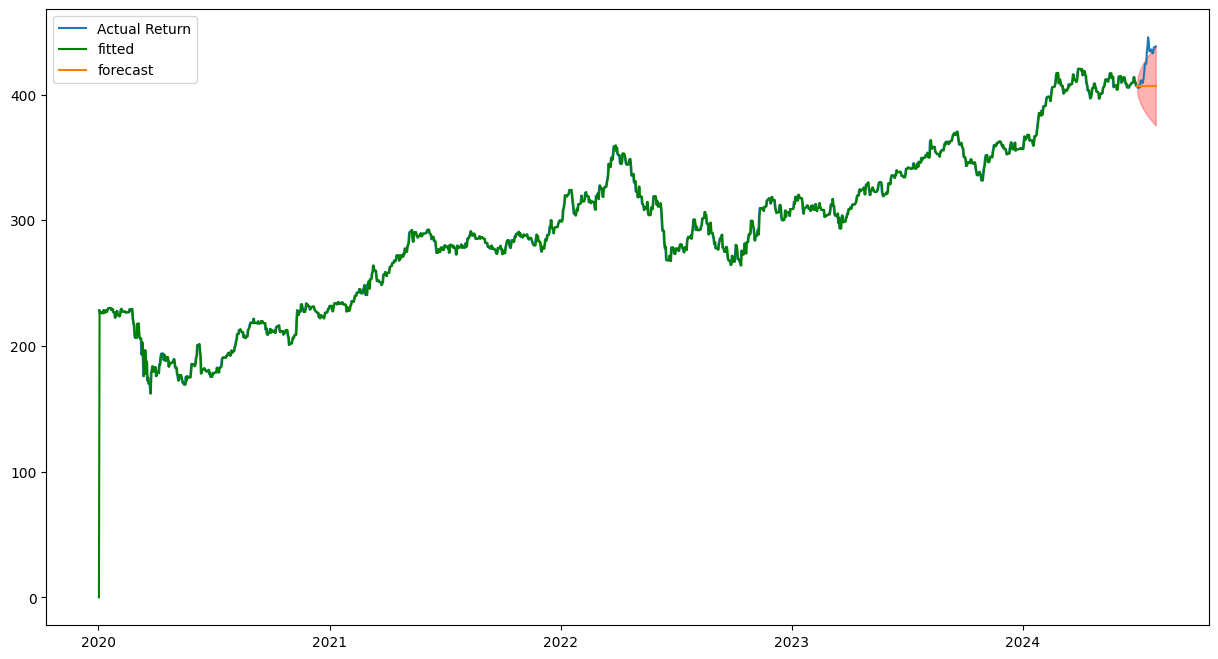

In [7]:
train = df.iloc[:-30]
test = df.iloc[-30:]

train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

arima = ARIMA(train['Close'], order=(0, 1, 0)).fit()
fig, ax= plt.subplots(figsize=(15,8))

# Plot the real values of stock prices
ax.plot(df['Close'], label='Actual Return')

# Plot fitted values of our model
train_pred = arima.fittedvalues
ax.plot(train.index, train_pred, color='green', label='fitted')

prediction_result = arima.get_forecast(30)
conf_int = prediction_result.conf_int()

# Plot lower and upper limits
lower = conf_int[conf_int.columns[0]]
upper = conf_int[conf_int.columns[1]]

forecast = prediction_result.predicted_mean

ax.plot(test.index, forecast, label='forecast')
ax.fill_between(test.index, lower, upper, color='red', alpha=0.3)
ax.legend()

### Evaluate Model
Using RMSE and MAE metrics to see the performance of our model

In [8]:
y_true = test['Close'].values
rmse = np.sqrt(mean_squared_error(y_true, forecast))
mae = mean_absolute_error(y_true, forecast)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 22.248062804324675
MAE: 18.150012207031214


# Linear Regression

In [9]:
lr_model = LinearRegression()
lr_model.fit(train[['date_ordinal']], train['Close'])
lr_forecast = lr_model.predict(test[['date_ordinal']])

### Compute RMSE and MAE

In [10]:
lr_rmse = np.sqrt(mean_squared_error(y_true, lr_forecast))
lr_mae = mean_absolute_error(y_true, lr_forecast)
print(f'RMSE: {lr_rmse}')
print(f'MAE: {lr_mae}')

RMSE: 31.580726027481326
MAE: 29.103639338446875


### Plot Linear Regression

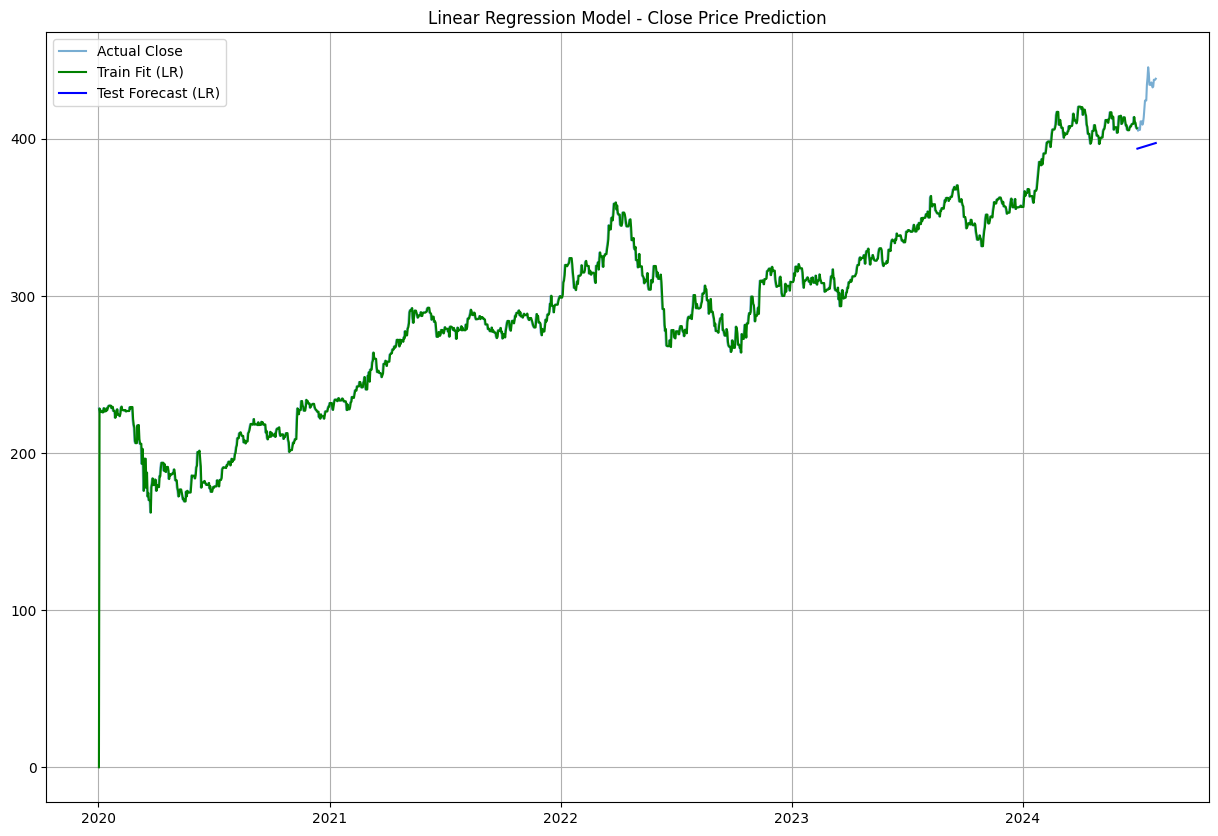

In [11]:
plt.figure(figsize=(15,10))
plt.plot(df.index, df['Close'], label='Actual Close', alpha=0.6)
plt.plot(train.index, train_pred, label='Train Fit (LR)', color='green')
plt.plot(test.index, lr_forecast, label='Test Forecast (LR)', color='blue')
plt.title('Linear Regression Model - Close Price Prediction')
plt.legend()
plt.grid(True)

# Random Forest

In [12]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train[['date_ordinal']], train['Close'])
rf_forecast = rf_model.predict(test[['date_ordinal']])

print(rf_forecast)

[406.98698975 406.98698975 406.98698975 406.98698975 406.98698975
 406.98698975 406.98698975 406.98698975 406.98698975 406.98698975
 406.98698975 406.98698975 406.98698975 406.98698975 406.98698975
 406.98698975 406.98698975 406.98698975 406.98698975 406.98698975
 406.98698975 406.98698975 406.98698975 406.98698975 406.98698975
 406.98698975 406.98698975 406.98698975 406.98698975 406.98698975]


### Compute RMSE + MAE

In [13]:
rf_rmse = np.sqrt(mean_squared_error(y_true, rf_forecast))
rf_mae = mean_absolute_error(y_true, rf_forecast)
print(f'RMSE: {rf_rmse}')
print(f'MAE: {rf_mae}')

RMSE: 22.097841493564125
MAE: 18.012877441406218


### Plot Random Forest

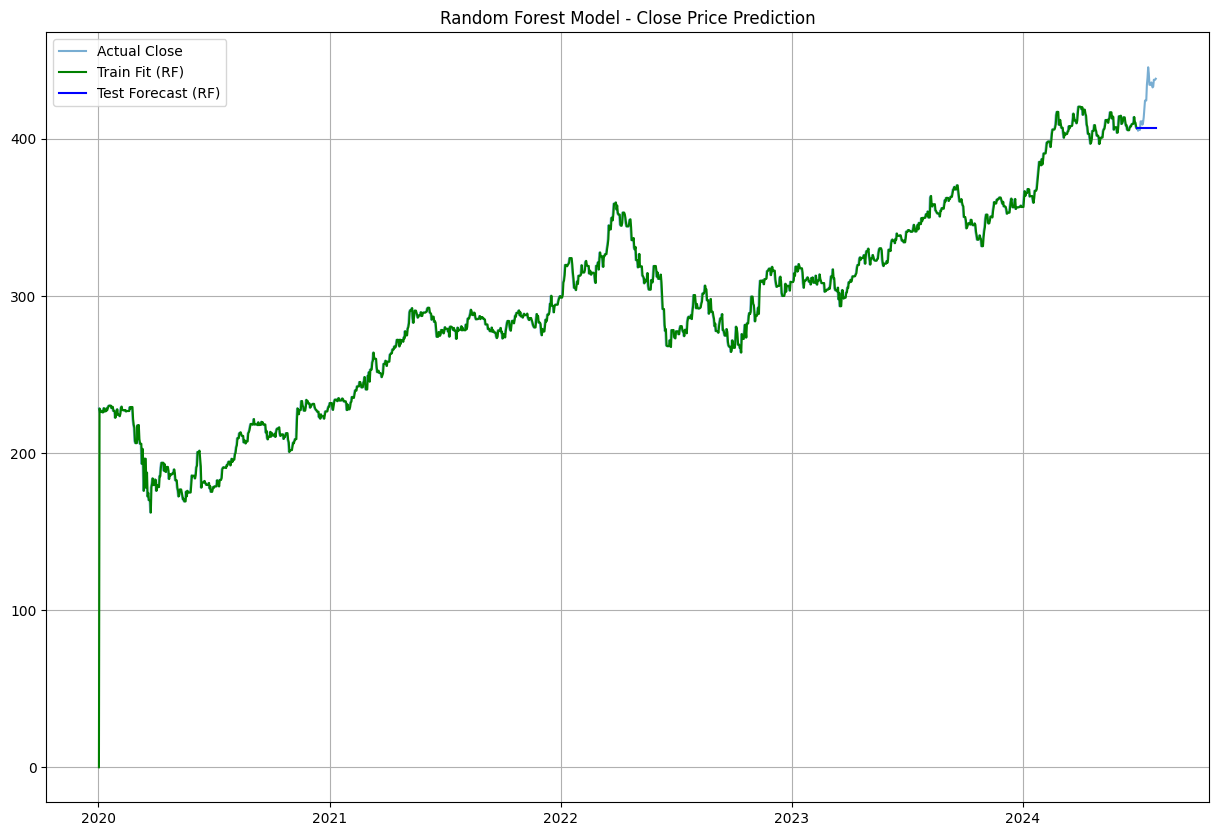

In [14]:
plt.figure(figsize=(15,10))
plt.plot(df.index, df['Close'], label='Actual Close', alpha=0.6)
plt.plot(train.index, train_pred, label='Train Fit (RF)', color='green')
plt.plot(test.index, rf_forecast, label='Test Forecast (RF)', color='blue')
plt.title('Random Forest Model - Close Price Prediction')
plt.legend()
plt.grid(True)

# Compare Baseline Models

In [15]:
print("ARIMA")
print(f'RMSE: {rmse}')
print(f'MAE: {mae}\n')

print("Linear Regression")
print(f'RMSE: {lr_rmse}')
print(f'MAE: {lr_mae}\n')

print("Random Forest")
print(f'RMSE: {rf_rmse}')
print(f'MAE: {rf_mae}')

ARIMA
RMSE: 22.248062804324675
MAE: 18.150012207031214

Linear Regression
RMSE: 31.580726027481326
MAE: 29.103639338446875

Random Forest
RMSE: 22.097841493564125
MAE: 18.012877441406218


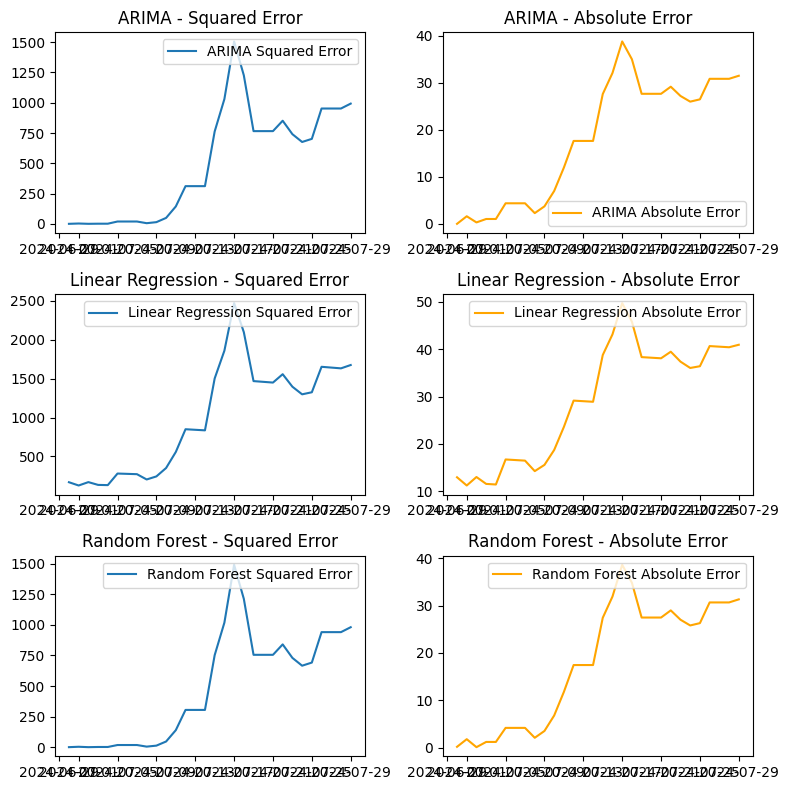

In [17]:
fig, axs = plt.subplots(3, 2, figsize=(8, 8))

# ARIMA Graph
arima_error = y_true - forecast
axs[0, 0].plot(test.index, arima_error**2, label='ARIMA Squared Error')
axs[0, 0].set_title('ARIMA - Squared Error')
axs[0, 0].legend()

axs[0, 1].plot(test.index, np.abs(arima_error), label='ARIMA Absolute Error', color='orange')
axs[0, 1].set_title('ARIMA - Absolute Error')
axs[0, 1].legend()

# Linear Regression Graph
lr_error = y_true - lr_forecast
axs[1, 0].plot(test.index, lr_error**2, label='Linear Regression Squared Error')
axs[1, 0].set_title('Linear Regression - Squared Error')
axs[1, 0].legend()

axs[1, 1].plot(test.index, np.abs(lr_error), label='Linear Regression Absolute Error', color='orange')
axs[1, 1].set_title('Linear Regression - Absolute Error')
axs[1, 1].legend()

# Random Forest Graph
rf_error = y_true - rf_forecast
axs[2, 0].plot(test.index, rf_error**2, label='Random Forest Squared Error')
axs[2, 0].set_title('Random Forest - Squared Error')
axs[2, 0].legend()

axs[2, 1].plot(test.index, np.abs(rf_error), label='Random Forest Absolute Error', color='orange')
axs[2, 1].set_title('Random Forest - Absolute Error')
axs[2, 1].legend()

plt.tight_layout()
plt.show()